## 1. Препроцессинг графа в `dgl`

DGL (Deep Graph Library)  - это пакет, разработанный для обучения и использования моделей графовых нейронных сетей. В данном пакете реализовано большое количество ставших уже классическими модулей (например, GraphConv, GraphSage и т.д.), на основе которых можно разрабатывать собственные модели. DGL предоставляет большой набор возможностей: работа с GPU, возможности для работы с большими графами и т.д.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools

import dgl
import dgl.nn as gnn
from dgl.nn import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

В `dgl` граф - объект класс `DGLGraph`. Для его создания нужно указать:
* тензор начальных узлов для ребер
* тензор конечных узлов для ребер
* кол-во вершин (узлы нумеруются, начиная с 0; кол-во вершин можно не задавать, если они все перечислены в списках для создания ребер)

В `dgl` граф всегда ориентированный.

На узлах (`.ndata`) и ребрах (`.edata`) могут храниться атрибуты. Их особенности:
* только числовые тензоры;
* атрибуты всех узлов (ребер) должны иметь одинаковый размер;
* каждый атрибут имеет уникальное имя (атрибуты узлов и ребер могут иметь одинаковые имена);
* первая размерность тензора атрибутов должна быть равна кол-ву узлов (ребер);
* срез по строкам возвращает атрибуты одного узла (ребра)

Пример создания графа:
```python
G = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
G.ndata['x'] = torch.randn(6, 3)
G.ndata['y'] = torch.randint(0, 2, (6, ))
```

Кроме возможностей по созданию наборов данных, `dgl` предоставляет большой набор готовых датасетов в `dgl.data`.

`DGLGraph` имеют большое количество свойств и методов для работы с графовыми структурами, которые можно найти в [документации](https://docs.dgl.ai/api/python/dgl.DGLGraph.html)

### Работа с датасетом
Загрузим датасет `CoraGraphDataset` из `dgl.data`. Этот датасет состоит из одного графа. Посмотрим на:

* количество узлов в графе;
* количество ребер в графе;
* размерность атрибутов на узлах;
* количество классов узлов в датасете

Выделим подграф (`dgl.node_subgraph`), содержащий узлы, относящиеся к трем наиболее часто встречающимся классам.

In [2]:
dataset = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
print(f'Количество узлов в графе: {dataset[0].num_nodes()}\n')
print(f'Количество ребер в графе: {dataset[0].num_edges()}\n')
print('Размерность атрибутов на узлах:\n',*[f'Атрибут "{key}", размерность: {str(dataset[0].ndata[key].shape)}\n' for key in dataset[0].ndata.keys()])
print(f'Количество классов узлов в датасете: {dataset.num_classes}')

Количество узлов в графе: 2708

Количество ребер в графе: 10556

Размерность атрибутов на узлах:
 Атрибут "feat", размерность: torch.Size([2708, 1433])
 Атрибут "label", размерность: torch.Size([2708])
 Атрибут "test_mask", размерность: torch.Size([2708])
 Атрибут "val_mask", размерность: torch.Size([2708])
 Атрибут "train_mask", размерность: torch.Size([2708])

Количество классов узлов в датасете: 7


In [4]:
# Выделите подграф, содержащий узлы, относящиеся к трем наиболее часто встречающимся классам
class_id, class_count = torch.unique(dataset[0].ndata['label'], return_counts=True)
print('Тензоры класса и его частоты:',class_id, class_count)
top3_classes = class_count.argsort()[-3:]
print('Три наиболее часто встречающихся класса:',top3_classes)
print('Количество узлов для них:', sum(class_count.sort().values[-3:]))

def nodes_with_feature_one(nodes):
    '''Вспомогательная функция для фильтрации узлов'''
    return (torch.isin(nodes.data['label'], top3_classes))

filtered_nodes = dataset[0].filter_nodes(nodes_with_feature_one)
dgl.node_subgraph(dataset[0], filtered_nodes) #подграф, содержащий узлы, относящиеся к трем наиболее часто встречающимся классам

Тензоры класса и его частоты: tensor([0, 1, 2, 3, 4, 5, 6]) tensor([351, 217, 418, 818, 426, 298, 180])
Три наиболее часто встречающихся класса: tensor([2, 4, 3])
Количество узлов для них: tensor(1662)


Graph(num_nodes=1662, num_edges=5708,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64), '_ID': Scheme(shape=(), dtype=torch.int64)})

## 2. Создание графа
Файл `cities_nodes.csv` содержит данные о городах: название, страна, население, дату основания и координаты. В файле `cities_edges.csv` содержатся данные о связях между городам: города соединяются ребрами в случае, если в статье русскоязычной Википедии о городе присутсвует ссылка на страницу для другого города. Создадим на основе двух этих файлов `dgl.graph`. Для этого:

1. занумеруем города (узлы) целыми числами;
2. представим каждое ребро в виде пары двух целых чисел;
3. в качестве атрибутов (`g.ndata['feat']`) узлов используем логарифм численности населения в городе и входящую степень узлов (результат сохраним в виде двумерного тензора размера `(n_nodes, 2)` и приведем к `torch.float32`);
4. занумеруем страны целыми числами и в качестве меток узлов (`g.ndata['label']`) используем номер соотвествующей страны; используем тензор типа `torch.int64`;
5. в качестве атрибутов (`g.edata['distance']`) ребер используем логарифм расстояния между городами (результат сохраним в виде одномерного тензора размера `(n_edges, )` и приведем к `torch.float32`);
6. добавим графу атрибут `num_classes`, в котором будет храниться число классов (стран);
7. разобьем множество узлов на обучающее и валидационное множество в соотношении 90%-10%. Для представления каждого из множеств создадим булев тензор $t$ размерности, равной количеству узлов в графе, где $t[i]==True$, если узел $i$ входит в соответствующее множество. Добавим в словарь `ndata` два ключа `train_mask`, `val_mask`.


In [5]:
# 1. занумеруйте города (узлы) целыми числами;
nodes = pd.read_csv('data/cities_nodes.csv')
nodes = nodes.rename(columns={'Unnamed: 0':'city_label'})
nodes_cities = nodes.iloc[:,0].unique()

edges = pd.read_csv('data/cities_edges.csv')
edges_cities = pd.concat([edges.source, edges.target]).unique()

print(f'Городов в узлах: {len(nodes_cities)}. Городов в ребрах: {len(edges_cities)}. Количество одинаковое:',set(nodes_cities) == set(edges_cities))

city_cat = nodes.loc[:,'city_label'].astype('category')
city_to_number = {name:number for number,name in enumerate(city_cat.cat.categories)}
number_to_city = {number:name for number,name in enumerate(city_cat.cat.categories)}
nodes['city_encoded'] = nodes.loc[:,'city_label'].replace(city_to_number)
nodes = nodes.loc[:, ['city_label','city_encoded', 'country_label', 'population', 'inception', 'lat', 'long']]
nodes.head()

Городов в узлах: 315. Городов в ребрах: 315. Количество одинаковое: True


,city_label,city_encoded,country_label,population,inception,lat,long
0,Минск,185,Белоруссия,2009786,01.01.1067,27.561837,53.902246
1,Гомель,72,Белоруссия,510300,01.01.1142,30.983333,52.441667
2,Брест,43,Белоруссия,340318,01.01.1017,23.656944,52.084722
3,Гродно,76,Белоруссия,356900,01.01.1128,23.816667,53.666667
4,Вилейка,54,Белоруссия,27167,25.11.1460,26.916667,54.483333


In [6]:
# 2. представьте каждое ребро в виде пары двух целых чисел;
edges['source_encoded'] = edges.loc[:,'source'].replace(city_to_number)
edges['target_encoded'] = edges.loc[:,'target'].replace(city_to_number)
edges['source, target'] = list(zip(edges.loc[:,'source_encoded'], edges.loc[:,'target_encoded']))
edges.head()

,source,target,distance,source_encoded,target_encoded,"source, target"
0,Минск,Новополоцк,125.318358,185,202,"(185, 202)"
1,Минск,Могилёв,191.535637,185,188,"(185, 188)"
2,Минск,Слуцк,54.352190,185,242,"(185, 242)"
3,Минск,Барановичи,119.025908,185,26,"(185, 26)"
4,Минск,Бобруйск,123.884508,185,40,"(185, 40)"


In [7]:
g = dgl.graph((edges.source_encoded.to_numpy(),edges.target_encoded.to_numpy()))
g

Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={}
      edata_schemes={})

In [8]:
# 3. в качестве атрибутов (`g.ndata['feat']`) узлов используйте логарифм численности населения 
# в городе и входящую степень узлов (результат сохраните в виде двумерного тензора размера 
# `(n_nodes, 2)` и приведите к `torch.float32`);
nodes['log_population'] = np.log(nodes['population'])
nodes = nodes.loc[:,['city_label', 'city_encoded', 'country_label', 'population', 'log_population',
                 'inception', 'lat', 'long']]
nodes = nodes.sort_values('city_encoded')
nodes.head()

,city_label,city_encoded,country_label,population,log_population,inception,lat,long
187,Агдам,0,Азербайджан,3770,8.234830,01.01.1701,46.916667,39.983333
207,Агдаш,1,Азербайджан,29600,10.295530,01.01.1501,47.483333,40.650000
194,Агджабеди,2,Азербайджан,39200,10.576432,01.01.1593,47.450200,40.048939
239,Агстафа (город),3,Азербайджан,20200,9.913438,NaN,45.450000,41.116667
247,Аджикабул,4,Азербайджан,21504,9.975994,NaN,48.935000,40.037500


In [9]:
target_nodes = edges.groupby('target_encoded').count()[['source']].rename(columns={'source':'n_sources'})
nodes = nodes.set_index('city_encoded').join(target_nodes).sort_index().reset_index()
nodes.head()

,city_encoded,city_label,country_label,population,log_population,inception,lat,long,n_sources
0,0,Агдам,Азербайджан,3770,8.234830,01.01.1701,46.916667,39.983333,73
1,1,Агдаш,Азербайджан,29600,10.295530,01.01.1501,47.483333,40.650000,73
2,2,Агджабеди,Азербайджан,39200,10.576432,01.01.1593,47.450200,40.048939,73
3,3,Агстафа (город),Азербайджан,20200,9.913438,NaN,45.450000,41.116667,73
4,4,Аджикабул,Азербайджан,21504,9.975994,NaN,48.935000,40.037500,73


In [10]:
g.ndata['feat'] = torch.tensor(nodes[['log_population','n_sources']].to_numpy(), dtype=torch.float32)
g

Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={})

In [11]:
# 4. занумеруйте страны целыми числами и в качестве меток узлов (`g.ndata['label']`) 
# используйте номер соотвествующей страны; используйте тензор типа `torch.int64`;
country_list = sorted(nodes['country_label'].unique())
digit_to_country = {number:node for number,node in enumerate(country_list)}
country_to_digit = {node:number for number,node in enumerate(country_list)}
print(digit_to_country)
nodes['country_encoded'] = nodes['country_label'].replace(country_to_digit)
nodes = nodes.loc[:,['city_encoded','country_encoded', 'city_label', 
                     'country_label','population','log_population', 
                     'inception', 'lat', 'long', 'n_sources']]
nodes.head()

{0: 'Азербайджан', 1: 'Белоруссия', 2: 'Казахстан', 3: 'Молдавия'}


,city_encoded,country_encoded,city_label,country_label,population,log_population,inception,lat,long,n_sources
0,0,0,Агдам,Азербайджан,3770,8.234830,01.01.1701,46.916667,39.983333,73
1,1,0,Агдаш,Азербайджан,29600,10.295530,01.01.1501,47.483333,40.650000,73
2,2,0,Агджабеди,Азербайджан,39200,10.576432,01.01.1593,47.450200,40.048939,73
3,3,0,Агстафа (город),Азербайджан,20200,9.913438,NaN,45.450000,41.116667,73
4,4,0,Аджикабул,Азербайджан,21504,9.975994,NaN,48.935000,40.037500,73


In [12]:
g.ndata['label'] = torch.tensor(nodes['country_encoded'], dtype=torch.int64)
g

Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [13]:
# 5. в качестве атрибутов (`g.edata['distance']`) ребер используйте логарифм расстояния 
# между городами (результат сохраните в виде одномерного тензора размера `(n_edges, )` 
# и приведите к `torch.float32`);
edges['log_distance'] = np.log(edges['distance'])
edges.head()

/home/user/miniconda/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,source,target,distance,source_encoded,target_encoded,"source, target",log_distance
0,Минск,Новополоцк,125.318358,185,202,"(185, 202)",4.830857
1,Минск,Могилёв,191.535637,185,188,"(185, 188)",5.255074
2,Минск,Слуцк,54.352190,185,242,"(185, 242)",3.995485
3,Минск,Барановичи,119.025908,185,26,"(185, 26)",4.779341
4,Минск,Бобруйск,123.884508,185,40,"(185, 40)",4.819350


In [14]:
g.edata['distance'] = torch.tensor(edges['log_distance'], dtype=torch.float32)
g

Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

In [15]:
# 6. добавьте графу атрибут `num_classes`, в котором хранится число классов (стран);
country_number = len(digit_to_country)
print(f'Число классов (стран): {country_number}')
g.num_classes = country_number
g

Число классов (стран): 4


Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

In [16]:
# 7. разбейте множество узлов на обучающее и валидационное множество в соотношении 
# 90%-10%. Для представления каждого из множеств создайте булев тензор $t$ размерности, 
# равной количеству узлов в графе, где $t[i]==True$, если узел $i$ входит в 
# соответствующее множество. Добавьте в словарь `ndata` два ключа `train_mask`, 
# `val_mask`. __(1 балл)__

from sklearn.model_selection import train_test_split
tr, tst = train_test_split(nodes.city_encoded,test_size=0.1)
print(f'Узлов в обучающем/тестовом множестве: {len(tr)}/{len(tst)}')

train_mask = np.zeros(len(nodes.city_encoded))
train_mask[tr] = True
val_mask = np.zeros(len(nodes.city_encoded))
val_mask[tst] = True

g.ndata['train_mask'] = torch.tensor(train_mask)
g.ndata['val_mask'] = torch.tensor(val_mask)
g

Узлов в обучающем/тестовом множестве: 283/32


Graph(num_nodes=315, num_edges=12666,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.float64), 'val_mask': Scheme(shape=(), dtype=torch.float64)}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

## 3. Задача классификации узлов (городов по странам) 

`dgl` предоставляет [большое количество](https://docs.dgl.ai/api/python/nn.html) модулей-блоков для построения нейронных сетей. С точки зрения реализации они являются наследниками стандартного `torch.nn.Module`. Поэтому общая логика написания сети остается точно такой же, как и при использовании `torch`: вы описываете модель при помощи класса-наследника `torch.nn.Module`, определяете в методе `__init__` все необходимые блоки и реализуете метод `forward`, где вызываете модули в нужной последовательности. Кроме модулей графовых сетей вы можете использовать и "классические": `Linear`, `Dropout` и т.д.

В отличие от модулей из `torch`, где метод `forward` обычно ожидает один параметр на входе (как `Linear` ожидает один тензор), модули из `dgl` обычно ожидают 2 параметра: граф и матрицу атрибутов узлов. Конкретный модуль может ожидать и чего-то другого, поэтому рекомендуется сверяться с документацией.

Пример работы с модулями из `dgl`

```python
import dgl.nn as gnn
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
g = dgl.add_reverse_edges(g)
g.ndata['x'] = torch.randn(6, 3)

conv = gnn.GraphConv(3, 32)
h = conv(g, g.ndata['x'])
h.shape # h - тензор скрытых представлений узлов после свертки conv
```

Пример описания графовой нейронной сети при помощи `dgl`
```python
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
```

Используя граф, полученный в п.2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решим задачу классификации городов по странам (задача классификации узлов).

На каждой эпохе обучения будем выводить на экран следующую информацию:
1. Номер эпохи
2. Значение функции потерь на обучающем множестве
3. Значение метрики accuracy (`sklearn.metrics.accuracy_score`) на обучающем множестве
4. Значение метрики accuracy (`sklearn.metrics.accuracy_score`) на тестовом множестве

Важно: при расчете значения функции потерь при обучении используются только узлы, относящиеся к обучающему множеству! Узлы, относящиеся к валидационному множеству, для простоты оставлены в графе, но прогнозы для этих узлов не оказывают влияние на функцию потерь и обратное распространение ошибки при обучении.

In [17]:
from sklearn.metrics import accuracy_score

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [18]:
model = GCN(g.ndata['feat'].shape[1], 16, g.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask'].long()
val_mask = g.ndata['val_mask'].long()
for e in range(10):
    logits = model(g, features)
    pred = logits.argmax(1)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    
    train_acc_sklearn = accuracy_score(labels[train_mask],pred[train_mask])
    val_acc_sklearn = accuracy_score(labels[val_mask],pred[val_mask])
    print('loss:',loss.item(), '\ttrain_acc_sklearn:', train_acc_sklearn,'\tval_acc_sklearn:', val_acc_sklearn)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss: 8.863370895385742 	train_acc_sklearn: 0.0 	val_acc_sklearn: 0.0
loss: 5.422701358795166 	train_acc_sklearn: 0.0 	val_acc_sklearn: 0.0
loss: 2.0468878746032715 	train_acc_sklearn: 0.0 	val_acc_sklearn: 0.0
loss: 0.1761670559644699 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 0.008102119900286198 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 0.0005323420627973974 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 4.923221786157228e-05 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 5.960448106634431e-06 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 9.536742027194123e-07 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0
loss: 1.1920927533992653e-07 	train_acc_sklearn: 1.0 	val_acc_sklearn: 1.0


## 4. Задача предсказания связей

Используя граф, полученный в п.2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решим задачу предсказания связей. 

Цикл обучения состоит из следующих шагов:
1. получение представлений `h` узлов при помощи сети, аналогичной п.3;
2. конструирование графа отрицательных примеров (см функцию `construct_negative_graph`);
3. расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h` (см класс `MLPPredictor`) - для этих ребер модель должна предсказывать метку 1;
4. расчет прогнозов ребер на основе графа отрицательных примеров и скрытых представлений узлов `h` (см класс `MLPPredictor`) - для этих ребер модель должна предсказывать метку 0;
5. расчет функции потерь (например, `CrossEntropyLoss`) и шаг оптимизации.

На каждой эпохе обучения будем выводить на экран следующую информацию: `Номер эпохи`, `Значение функции потерь на обучающем множестве`.

Примечание: Для простоты в данной задаче не предполагается разбиение ребер на обучающее и тестовое множество. На каждой эпохе получение эмбеддингов `h` происходит только 1 раз на основе исходного графа.

In [19]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class MLPPredictor(nn.Module):
    '''Берет представления узлов, находящихся на концах ребер, 
    конкатенирует их и прогоняет через небольшую полносвязную
    сеть для получения прогноза вероятности существования ребра'''
    def __init__(self, h_feats, out_feats=2):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, out_feats)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def construct_negative_graph(g, k):
    '''Берет ребра из графа g и случайным образом заменяет вершины на концах ребер'''
    u, v = g.edges()
    neg_u = u.repeat_interleave(k).long()
    neg_v = torch.randint(0, g.num_nodes(), (len(neg_u),)).long()
    return dgl.graph((neg_u, neg_v), num_nodes=g.num_nodes())

In [20]:
g_neg = construct_negative_graph(g,1) # конструирование графа отрицательных примеров
model = GCN(g.ndata['feat'].shape[1], 16, g.num_classes)
pred = MLPPredictor(4)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

for e in range(100):
    h = model(g, g.ndata['feat']) # получение представлений `h` узлов
    pos_score = pred(g, h)[:, 0] # расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h`
    neg_score = pred(g_neg, h)[:, 0] # расчет прогнозов ребер на основе графа отрицательных примеров и и скрытых представлений узлов `h`
    loss = compute_loss(pos_score, neg_score) # расчет функции потерь 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # и шаг оптимизации
    
    print(f'In epoch {e}, loss: {loss}')

In epoch 0, loss: 1.3163032531738281
In epoch 1, loss: 1.0290980339050293
In epoch 2, loss: 0.9911626577377319
In epoch 3, loss: 0.8579697012901306
In epoch 4, loss: 0.789504885673523
In epoch 5, loss: 0.7997952699661255
In epoch 6, loss: 0.8017380833625793
In epoch 7, loss: 0.7687914371490479
In epoch 8, loss: 0.7302601337432861
In epoch 9, loss: 0.7089563012123108
In epoch 10, loss: 0.708361804485321
In epoch 11, loss: 0.7159078121185303
In epoch 12, loss: 0.7158103585243225
In epoch 13, loss: 0.7052422165870667
In epoch 14, loss: 0.6893916130065918
In epoch 15, loss: 0.6742038130760193
In epoch 16, loss: 0.6666017770767212
In epoch 17, loss: 0.6737493872642517
In epoch 18, loss: 0.6770161986351013
In epoch 19, loss: 0.6710129380226135
In epoch 20, loss: 0.6581619381904602
In epoch 21, loss: 0.6432657837867737
In epoch 22, loss: 0.6336507201194763
In epoch 23, loss: 0.63222736120224
In epoch 24, loss: 0.6310726404190063
In epoch 25, loss: 0.6248013973236084
In epoch 26, loss: 0.61454

## 5. Задача регрессии на ребрах (предсказание расстояния между городами)
Используя граф, полученный в п.2, и графовую нейронную сеть, написанную с использованием библиотеки `dgl`, решим задачу предсказания расстояния между городами (задача регрессии на ребрах).

Цикл обучения состоит из следующих шагов:
1. получение представлений `h` узлов при помощи сети, аналогичной п.3;
2. расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h` (см класс `MLPPredictor`);
3. расчет функции потерь (например, `MSELoss`) и шаг оптимизации.

На каждой эпохе обучения будем выводить на экран следующую информацию: `Номер эпохи` и `Значение функции потерь на обучающем множестве`.

Примечание: Для простоты, в данной задаче не предполагается разбиение ребер на обучающее и тестовое множество.

In [21]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [22]:
g = dgl.add_edges(g, g.edges()[1],g.edges()[0]) # make the graph symmetric
node_features = g.ndata['feat']
edge_label = g.edata['distance']        
model = GCN(2, 20, 5)
pred = MLPPredictor(5, 1) 
opt = torch.optim.Adam(model.parameters())

for epoch in range(100):
    h = model(g, node_features) # получение представлений `h` узлов при помощи сети
    score = pred(g, h) # расчет прогнозов ребер на основе исходного графа и скрытых представлений узлов `h` 
    loss = ((score[train_mask] - edge_label[train_mask]) ** 2).mean() # расчет функции потерь 
    opt.zero_grad()
    loss.backward()
    opt.step() # шаг оптимизации
    print(f'{epoch=}, loss=', loss.item()) # Номер эпохи и Значение функции потерь на обучающем множестве

epoch=0, loss= 19.61073112487793
epoch=1, loss= 18.465789794921875
epoch=2, loss= 17.34561538696289
epoch=3, loss= 16.25374984741211
epoch=4, loss= 15.192285537719727
epoch=5, loss= 14.1597900390625
epoch=6, loss= 13.159599304199219
epoch=7, loss= 12.194966316223145
epoch=8, loss= 11.266158103942871
epoch=9, loss= 10.373331069946289
epoch=10, loss= 9.518782615661621
epoch=11, loss= 8.702608108520508
epoch=12, loss= 7.9250335693359375
epoch=13, loss= 7.187564849853516
epoch=14, loss= 6.490784645080566
epoch=15, loss= 5.834165573120117
epoch=16, loss= 5.217741966247559
epoch=17, loss= 4.641526699066162
epoch=18, loss= 4.104678630828857
epoch=19, loss= 3.6069161891937256
epoch=20, loss= 3.1478347778320312
epoch=21, loss= 2.726534605026245
epoch=22, loss= 2.341336727142334
epoch=23, loss= 1.990516185760498
epoch=24, loss= 1.672426462173462
epoch=25, loss= 1.388039231300354
epoch=26, loss= 1.135667324066162
epoch=27, loss= 0.9123569130897522
epoch=28, loss= 0.7167673110961914
epoch=29, loss

## 6. Визуализируем сеть, используя Метод главных компонент.

Сведем эмбеддинги узлов, полученные при обучении модели в п.5, к векторам размерности 2, используя метод главных компонент (`sklearn.decomposition.PCA`). Визуализируем сеть, используя теперь для координат точек векторное представление узлов размерности 2. Покажем цветом узла страну, к которой относится город.

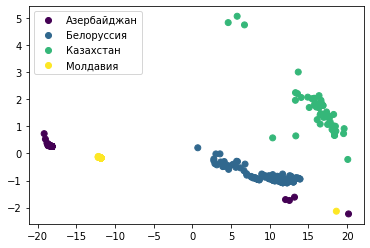

In [23]:
pca = PCA(n_components=2)
h_2d = pca.fit_transform(h.detach().numpy())
scatter = plt.scatter(h_2d[:,0], h_2d[:,1], c = nodes.country_encoded)
plt.legend(handles=scatter.legend_elements()[0], labels=list(digit_to_country.values()))

Вывод: эмбеддинги узлов хорошо разделили города по кластерам стран